# Notebook for social neural population decoding (NPD)
With inspiration from:
"The geometry of hippocampal CA2 representations enables abstract coding of social familiarity and identity" - Boyle 2022

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import data_processing as dp
from utils import *

In [3]:
# change matplotlib default figsize and fonts
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [4]:
# get actions
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions
# actions
list(actions.keys())


['002-050721-3',
 '002-050721-2',
 '001-280721-3',
 '145-141021-2',
 '011-120321-2',
 '011-surgery-implantation',
 '002-050721-1',
 '145-141021-4',
 '001-280721-5',
 '145-141021-5',
 '137-230121-6',
 '011-120321-6',
 '001-280721-1',
 '137-230121-3',
 '001-290721-2',
 '011-120321-3',
 '145-141021-3',
 '145-141021-6',
 '002-050721-5',
 '011-adjustment',
 '001-290721-1',
 '002-050721-4',
 '011-120321-4',
 '001-290721-3',
 'identify-neurons',
 '001-280721-4',
 '011-120321-5',
 '137-230121-5',
 '137-230121-2',
 '145-141021-1',
 '001-280721-2',
 '137-230121-4']

### Initialise data loader

In [5]:
# remove leading and trailing recording data
t_start = 0
t_stop = None # None => don't remove anything

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=False, baseline_duration=None,
)

### Load data (tracking and spikes), and use unique unit IDs

In [6]:
identify_neurons = project.require_action('identify-neurons')
identify_neurons = pd.read_csv(identify_neurons.data_path() / "units.csv")
identify_neurons.head()

,unit_name,unit_idnum,unit_id,action,channel_group,max_dissimilarity,max_depth_delta
0,414,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-4,1,0.05,100
1,1880,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-3,1,0.05,100
2,1153,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-5,1,0.05,100
3,321,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-6,1,0.05,100
4,1248,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-2,1,0.05,100


In [7]:
identify_neurons['unit_name']

0       414
1      1880
2      1153
3       321
4      1248
       ... 
153    1165
154    1495
155    1567
156    1569
157     215
Name: unit_name, Length: 158, dtype: int64

In [8]:
# select actions to include
actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6']

# load all tracking data (dict)trial x (dict)track_quantities x (array)time
tracking = {action_id:data_loader.tracking(action_id) for action_id in actions}

# process tracking
t_start, t_stop = 0, 1200
for action_id in tracking:
    # transform coordinates
    newx, newy = transform_coordinates(**tracking[action_id])
    tracking[action_id]['x'] = newx
    tracking[action_id]['y'] = newy
    # truncate recordings
    tracking[action_id].update(truncate_tracking_dict(tracking[action_id], t_start, t_stop))
    # define corner masks on trials
    tracking[action_id]['cms'] = corner_masks(**tracking[action_id])
        
        
# load all spikes data (dict)trial x (dict)unit_id x spike_train
# and use identify-neurons to assign unique IDs to each unit
spikes = {}
for action_id in tqdm.tqdm(actions):
    spikes[action_id] = {}
    channel_grps = dp.get_channel_groups(data_loader.data_path(action_id))
    action_mask = identify_neurons['action'] == action_id
    for channel_grp in channel_grps:
        spike_train = data_loader.spike_trains(action_id, channel_grp)
        for unit_id in spike_train:
            unique_unit_id_idx = (identify_neurons['unit_name'] == unit_id) & action_mask
            unique_unit_id = identify_neurons['unit_id'][unique_unit_id_idx].item()
            spikes[action_id][unique_unit_id] = truncate_spikes(spike_train[unit_id], tracking[action_id]["t"])
        # load units and "flatten" channel_grps dimension. - assuming units are unique OR duplicates across channels
        #spikes[action_id].update(data_loader.spike_trains(action_id, channel_grp))
        
# find persistent units (intersection over trials)
punits = persistent_units(spikes)
punits

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


['35eea67f-545f-4114-aa21-4f0e45fb94eb',
 '18141e4f-f245-4d81-a2b5-8d071dfa0457',
 '87d8a331-3b4b-404b-9bc4-584381d5da7e',
 'eac979e3-01c5-44a0-a1f5-21a5540a010b',
 '13da002c-9870-42db-87e0-0f6ff9b05bd2',
 'a7e4293f-b726-4f91-9582-1444f2af8487',
 '48959fa4-33ea-463a-abc1-7fd13a3b0b52',
 '7c4b7b9a-74f7-46b4-b01f-5d12b0067997',
 '362b87d9-b8cd-4ac9-bf7c-c00826ac5b19',
 'cb7c405a-c65e-4f34-acfd-db341c9f9bdc',
 'bfa84900-db4a-416a-a9b0-3378262d8ca3',
 'bc7338b1-0ac4-4019-a8f6-1f6b0711bcc8',
 'a12b5b5c-bc3b-4669-bd8f-5f58013f008a',
 '26d4502a-4d89-49a0-9214-1646ce5c2595',
 '9dcbbcc4-df72-489d-85da-70c1cc3ab159']

### Example tracking, masks and ratemap

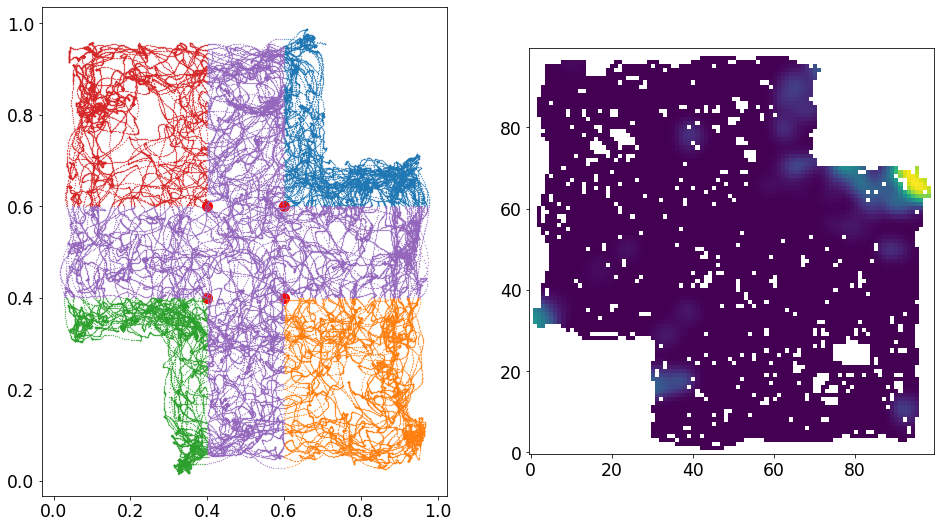

In [9]:
action_id = '011-120321-2'
unit_id = '13da002c-9870-42db-87e0-0f6ff9b05bd2'

# inspect spatial (corner) masking
fig, ax = plt.subplots(ncols=2)
#plt.plot(tracking['011-280721-1']['x'], tracking['011-280721-1']['y'])
margin = 0.40
BL=(0+margin,0+margin)
TL=(0+margin,1-margin)
TR=(1-margin,1-margin)
BR=(1-margin,0+margin)
ax[0].scatter(*BL, color = 'red', s=100)
ax[0].scatter(*TL, color = 'red', s=100)
ax[0].scatter(*TR, color = 'red', s=100)
ax[0].scatter(*BR, color = 'red', s=100)

pos = np.array([tracking[action_id]['x'], tracking[action_id]['y']]).T
cms = corner_masks(*pos.T)
for cm in cms.T:
    ax[0].scatter(*pos[cm].T, s=0.1)

# quick ratemap plot
x,y,t = tracking[action_id]['x'], tracking[action_id]['y'], tracking[action_id]['t']
spike_times = spikes[action_id][unit_id].times
import spatial_maps as sm
smap = sm.SpatialMap(x,y,t,spike_times,1,0.01)
ax[1].imshow(smap.rate_map(0.02,mask_zero_occupancy=True),origin='lower')

In [10]:
# show number of spikes per unit
"""
spiking = []
for action_str in spikes:
    for unit in spikes[action_str].values():
        spiking.append(unit.times.size)
print(spiking, max(spiking))
"""

'\nspiking = []\nfor action_str in spikes:\n    for unit in spikes[action_str].values():\n        spiking.append(unit.times.size)\nprint(spiking, max(spiking))\n'

### Setup input data and labels
This should follow the format:
- X.shape = (samples, num_features) -> neural rate activity
- y.shape = (samples) -> scalars indicating labelled class

In [11]:
window_size = 0.1 # in seconds
res = 10 # spatial/social resolution
X = []
y = []

for action_str in actions:
    labels = social_label(project.require_action(action_str))['s'] # select 's' for animals or 'o' for objects
    _,_,t,_,cms = tracking[action_str].values()
    #pspikes = [spikes[action_str][punit].times for punit in punits]
    #f_space = interp1d(t, np.stack([x,y]))
    f_labels = interp1d(t, cms.T, kind='nearest', fill_value='extrapolate')
    
    trial_duration = t[-1] - t[0]
    num_samples = int(trial_duration / window_size) - 1
    X_tmp = np.zeros((len(punits), num_samples))
    y_tmp = np.zeros((num_samples))
    
    for i in tqdm.trange(num_samples):
        time_window = (i*window_size, (i+1)*window_size)
        rat_pos = f_labels(np.linspace(*time_window, res))
        idx = np.argmax(np.sum(rat_pos,axis=-1))
        if idx == 4:
            # rat in middle of box / not socializing
            continue
        y_tmp[i] = labels[idx]
        
        for j, punit in enumerate(punits):
            unit_rate = np.sum((time_window[0] <= spikes[action_str][punit]) & (spikes[action_str][punit] <= time_window[1]))
            X_tmp[j,i] = unit_rate
    X.append(X_tmp)
    y.append(y_tmp)

X = np.concatenate(X,axis=1).T
y = np.concatenate(y).T
print(X.shape, y.shape)

100%|██████████| 11998/11998 [00:02<00:00, 4947.17it/s]

(59990, 15) (59990,)


In [12]:
# choose categories to include in analysis
f_vs_n_mask = np.logical_or(y == 1, y == 2)
y = y[f_vs_n_mask]
X = X[f_vs_n_mask]

## MACHINE LEARNING

In [13]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [14]:
categories, counts = np.unique(y, return_counts=True)
print(f"Categories: {categories}.", "Probability of category:", counts/np.sum(counts))

print("\n SVM score: ", clf.score(X_test,y_test))

Categories: [1. 2.]. Probability of category: [0.8172178 0.1827822]

 SVM score:  0.8280432507847925
